In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer   
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder  
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import set_config
import optuna
import category_encoders as ce

# 사전 데이터 작업

### interest_rate
-한국은행 기준 금리 feature

- 사전 작업이라 주석 처리하겠습니다

In [124]:
'''
train=pd.read_csv("train.csv", encoding='utf-8') 
test =pd.read_csv("test.csv", encoding='utf-8')

# 한국은행 기준 금리 데이터
interest_rate = pd.read_csv('interest_rate.csv', encoding='utf-8')
'''

In [125]:
'''
train['day'] = train.transaction_date.apply(lambda x: x[-2:])
test['day'] = test.transaction_date.apply(lambda x: x[-2:])

def preprocess_date(x):
    if type(x) == int:
        if x < 10:
            return '0'+str(x)
        else:
            return str(x)
    else:
        return x
    
train['day'] = train['day'].apply(preprocess_date)
test['day'] = test['day'].apply(preprocess_date)
'''


In [126]:
'''
train['transaction_date2'] = train['transaction_year_month'].astype(int).astype(str) + train['day'].astype(str)
train['transaction_date2'] = pd.to_datetime(train['transaction_date2'])

test['transaction_date2'] = test['transaction_year_month'].astype(int).astype(str) + test['day'].astype(str)
test['transaction_date2'] = pd.to_datetime(test['transaction_date2'])

train['transaction_year'] = train['transaction_date2'].dt.year
train['transaction_month'] = train['transaction_date2'].dt.month

test['transaction_year'] = test['transaction_date2'].dt.year
test['transaction_month'] = test['transaction_date2'].dt.month
'''

In [127]:
'''
def make_date(row):
    month_day = row['월일'].replace('월 ', '-')
    month_day = month_day.replace('일', '')
    date = str(row['연도'])+ '-' + month_day
    return date

interest_rate['날짜'] = interest_rate.apply(lambda x: make_date(x), axis=1)
interest_rate['날짜'] = pd.to_datetime(interest_rate['날짜'])
'''

In [128]:
'''
interest_rate['year'] = interest_rate['날짜'].dt.year
interest_rate['month'] = interest_rate['날짜'].dt.month
interest_rate['day'] = interest_rate['날짜'].dt.day
interest_rate = interest_rate[['날짜','year','month','day','금리']]
interest_rate = interest_rate[interest_rate['year']>=2007]
interest_rate.head()
'''

,날짜,year,month,day,금리
0,2023-01-13,2023,1,13,3.50
1,2022-11-24,2022,11,24,3.25
2,2022-10-12,2022,10,12,3.00
3,2022-08-25,2022,8,25,2.50
4,2022-07-13,2022,7,13,2.25


In [46]:
'''
from tqdm import tqdm
for idx, row in tqdm(train.iterrows(), total = train.shape[0]):
    date = row['transaction_date2']
    rate = interest_rate[interest_rate['날짜'] <= date].iloc[0]['금리']
    train.loc[idx, 'interest_rate'] = rate
'''

"\nfrom tqdm import tqdm\nfor idx, row in tqdm(train.iterrows(), total = train.shape[0]):\n    date = row['transaction_date2']\n    rate = interest_rate[interest_rate['날짜'] <= date].iloc[0]['금리']\n    train.loc[idx, 'interest_rate'] = rate\n"

In [ ]:
'''
from tqdm import tqdm
for idx, row in tqdm(test.iterrows(), total = test.shape[0]):
    date = row['transaction_date2']
    rate = interest_rate[interest_rate['날짜'] <= date].iloc[0]['금리']
    test.loc[idx, 'interest_rate'] = rate
'''

100%|██████████| 364966/364966 [16:52<00:00, 360.54it/s]


In [ ]:
'''
train.drop(['transaction_date2','transaction_year','transaction_month','day'],axis=1, inplace=True)
test.drop(['transaction_date2','transaction_year','transaction_month','day'],axis=1, inplace=True)
'''

In [ ]:
# train.to_csv('train_interest.csv', index=False)
# test.to_csv('test_interest.csv', index=False)

# 데이터 불러오기

In [2]:
train=pd.read_csv("train_interest.csv", encoding='utf-8') # 금리 feature 포함
test =pd.read_csv("test_interest.csv", encoding='utf-8') # 금리 feature 포함
child=pd.read_csv("day_care_center.csv", encoding='utf-8')
park=pd.read_csv("park.csv", encoding='utf-8')
submission = pd.read_csv('submission.csv')

# Feature Engineering

### floor 전처리
- 최소값이 -4이므로 4를 더해서 음수를 없앰

In [3]:
train['floor'] = train['floor'].map(lambda x: x+4)
test['floor'] = test['floor'].map(lambda x: x+4)

### bucket_area
 - 아파트 면적 기준 그룹화

In [4]:
def make_area_bucket(area):
    if area <= 40:
        return 0
    elif area < 60: # 59타입
        return 1
    elif area < 85: # 84타입
        return 2
    else:
        return 3

train['bucket_area'] = train['exclusive_use_area'].apply(make_area_bucket)
test['bucket_area'] = test['exclusive_use_area'].apply(make_area_bucket)
train['bucket_area'].value_counts()

2    370993
1    279988
3    155373
0     45233
Name: bucket_area, dtype: int64

### new_area
- 10단위로 새로운 면적 feature 생성

In [5]:
def make_new_area(area):
    return (area//10)*10
    

train['new_area'] = train['exclusive_use_area'].apply(make_new_area)
train['new_area'] = train['new_area'].astype(int)

test['new_area'] = test['exclusive_use_area'].apply(make_new_area)
test['new_area'] = test['new_area'].astype(int)

train['new_area'].value_counts()

80     287186
50     206660
40      73328
70      51664
110     41330
60      37622
30      31151
100     23419
120     21991
130     20197
90      11160
140     10591
20       8507
150      6439
160      5976
10       5574
170      2857
180      1712
190      1177
200       839
240       754
210       697
230       331
220       321
250        55
260        26
270        18
310         2
280         1
0           1
420         1
Name: new_area, dtype: int64

### pyung_area
- 아파트 평수

In [6]:
train['pyung_area'] = train['exclusive_use_area'] * 0.3025
test['pyung_area'] = test['exclusive_use_area'] * 0.3025

### cluster
- apartment_id 기준 군집화

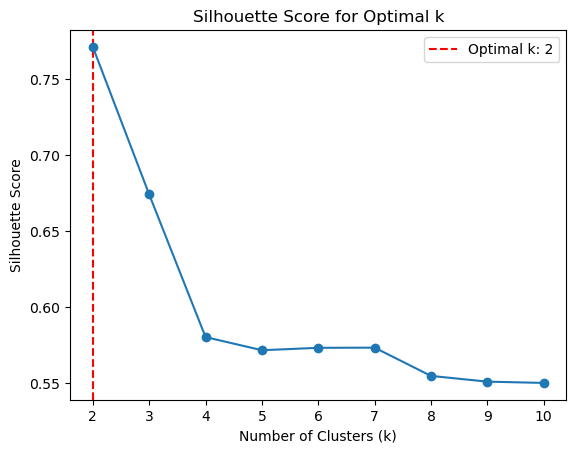

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 아파트 아이디와 거래가격 데이터를 선택합니다.
data = train[['apartment_id', 'transaction_real_price']]

# 아파트 아이디로 그룹화한 후 평균을 구합니다.
data = data.groupby(['apartment_id']).mean()

# 거래가격을 numpy 배열로 변환하고 1차원으로 변경합니다.
arr = data['transaction_real_price'].to_numpy().reshape(-1, 1)

# Silhouette 계수를 계산하여 최적의 군집 개수를 찾습니다.
silhouette_scores = []
k_range = range(2, 11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(arr)
    silhouette_scores.append(silhouette_score(arr, cluster_labels))

# 최적의 군집 개수를 가진 인덱스를 찾습니다.
optimal_k_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = k_range[optimal_k_index]

# 최적의 k 지점에 빨간색 점선을 그립니다.
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k: {optimal_k}')

# Silhouette 계수를 그래프로 표시합니다.
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(k_range)
plt.legend()
plt.show()

In [8]:
## 군집화 진행
optimal_k =  2
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
kmeans.fit(arr)

# 가격을 기준으로 군집의 순서를 정렬하기 위해 인덱스를 추출
sort_order = np.argsort(kmeans.cluster_centers_.flatten())

# 군집화 결과를 가격 순서대로 재할당
labels = np.zeros_like(kmeans.labels_)
for i, cluster in enumerate(sort_order):
    labels[kmeans.labels_ == cluster] = i

# 군집화 결과와 가격을 데이터에 추가
data['cluster'] = labels
data = data.reset_index()
data = data[['apartment_id', 'cluster']]
data

,apartment_id,cluster
0,0,0
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
12384,12654,0
12385,12655,0
12386,12656,1
12387,12657,1


In [9]:
train= pd.merge(train, data, how='left', left_on='apartment_id', right_on='apartment_id')
train['cluster'].value_counts()

0    772105
1     79482
Name: cluster, dtype: int64

In [10]:
test = pd.merge(test, data, how='left', left_on='apartment_id', right_on='apartment_id')
test['cluster'].value_counts()

0.0    330862
1.0     33885
Name: cluster, dtype: int64

### gu
- 자치구 feature 생성

In [11]:
region = pd.read_excel('행정구역분류_2023.10.1기준.xlsx')
region = region[(region['시도'] == '서울특별시') | (region['시도'] == '부산광역시')]
region = region[['시도','시군구','법정동']]
region.head()

,시도,시군구,법정동
0,서울특별시,서울특별시,서울특별시
1,서울특별시,종로구,종로구
2,서울특별시,종로구,청운동
3,서울특별시,종로구,신교동
4,서울특별시,종로구,궁정동


In [12]:
# 읍과 리가 있는 경우 '리' 부분 제거
train['dong'] = train['dong'].str.split(' ', expand=True).iloc[:, 0]
test['dong'] = test['dong'].str.split(' ', expand=True).iloc[:, 0]

In [13]:
# 자치구(gu) feature 생성
mapping_dict = dict(zip(region['시도'] + region['법정동'], region['시군구']))

train['gu'] = train['city'] + train['dong']
train['gu'] = train['gu'].map(mapping_dict)
train['gu'].fillna(0, inplace= True)

test['gu'] = test['city'] + test['dong']
test['gu'] = test['gu'].map(mapping_dict)
test['gu'].fillna(0, inplace= True)

### day

In [14]:
train['day'] = train.transaction_date.apply(lambda x: x[-2:])
del train['transaction_date']

test['day'] = test.transaction_date.apply(lambda x: x[-2:])
del test['transaction_date']

### age
- 아파트 나이

In [15]:
train['age'] = 2017 - train['year_of_completion']
train.drop('year_of_completion', axis=1, inplace=True)

test['age'] = 2017 - test['year_of_completion']
test.drop('year_of_completion', axis=1, inplace=True)

### 공원수

In [16]:
num_park_per_dong = park.groupby(['city', 'gu', 'dong'], as_index=False)['park_name'].count()
num_park_per_dong.rename({'park_name':'공원수'}, axis=1, inplace=True)

train = pd.merge(train, num_park_per_dong, left_on=['city', 'gu', 'dong'], right_on=['city', 'gu', 'dong'], how='left')
train['공원수'].fillna(0, inplace= True)
train.head()

test = pd.merge(test, num_park_per_dong, left_on=['city', 'gu', 'dong'], right_on=['city', 'gu', 'dong'], how='left')
test['공원수'].fillna(0, inplace=True)

### 어린이집 수

In [17]:
num_child_per_gu = child.groupby(['city', 'gu'], as_index=False)['day_care_name'].count()
num_child_per_gu.rename({'day_care_name':'어린이집수'}, axis=1, inplace=True)

train = pd.merge(train, num_child_per_gu, left_on=['city', 'gu'], right_on=['city', 'gu'], how='left')
train['어린이집수'].fillna(0, inplace= True)
train.head()

test = pd.merge(test, num_child_per_gu, left_on=['city', 'gu'], right_on=['city', 'gu'], how='left')
test['어린이집수'].fillna(0, inplace= True)

### 지하철역 개수

In [18]:
seoul_subway = pd.read_csv('서울지하철.csv', encoding='cp949')
busan_subway = pd.read_csv("부산지하철.csv", encoding='cp949')

In [19]:
busan_subway = busan_subway[['역명', '도로명주소']]
seoul_subway = seoul_subway[['역명', '도로명주소']]
subway = pd.concat([busan_subway, seoul_subway])

In [20]:
# 도로명주소에서 구 정보 추출
subway['지하철역개수'] = subway['도로명주소'].apply(lambda x: x.split()[1])

# 각 자치구에 속하는 지하철역 개수 세기
subway_counts_by_gu = subway['지하철역개수'].value_counts()

In [21]:
# 'gu' 컬럼을 기준으로 두 데이터프레임을 합침
train = pd.merge(train, subway_counts_by_gu, how='left', left_on='gu', right_index=True)

# 'gu' 컬럼을 기준으로 두 데이터프레임을 합침
test = pd.merge(test, subway_counts_by_gu, how='left', left_on='gu', right_index=True)

### top10
- top 10 시공사 아파트 여부를 나타내는 feature 생성

In [22]:
train['top10'] = 0
test['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train['apt'] = train['apt'].fillna('others')

# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    train.loc[train['apt'].str.contains(brand), 'top10'] = 1
    test.loc[test['apt'].str.contains(brand), 'top10'] = 1

### apt 통일화 및 transformed feature 생성

In [23]:
from tqdm import tqdm

# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names

# `apt_names_list`의 키워드에 해당하는 아파트명이 있는지 여부를 나타내는 새로운 컬럼 생성
train['transformed'] = False
test['transformed'] = False

# `apt_names_list`의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일함
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    train.loc[train['apt'].str.contains(a), 'apt'] = a
    test.loc[test['apt'].str.contains(a), 'apt'] = a
    train.loc[train['apt'].str.contains(a), 'transformed'] = True
    test.loc[test['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    train.loc[~train['transformed'], 'apt'] = 'others'
    test.loc[~test['transformed'] , 'apt'] = 'others'

100%|██████████| 25/25 [00:00<00:00, 28.47it/s]


# Encoding

### dong 인코딩

In [24]:
from tqdm import tqdm
import re

# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 
dong_price = train.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)

from tqdm import tqdm
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    try:
        train.loc[train['dong'] == d, 'dong'] = i
        test.loc[test['dong'] == d, 'dong'] = i
    except KeyError:
        new_index = len(dong_price)
        dong_price.loc[d] = new_index
        train.loc[train['dong'] == d, 'dong'] = new_index
        test.loc[test['dong'] == d, 'dong'] = new_index

test.loc[test['dong'] == '옥인동', 'dong'] = 48


#괄호와 괄호안내용 제거
regex = "\(.*\)|\s-\s.*"
for i in tqdm(range(len(train))):
   train.at[i, 'apt'] = re.sub(regex, '', train.at[i, 'apt'])
for i in tqdm(range(len(test))):
   test.at[i, 'apt'] = re.sub(regex, '', test.at[i, 'apt'])

100%|██████████| 364966/364966 [00:03<00:00, 100137.64it/s]


### city 인코딩

In [25]:
train['city'] = train['city'].map(lambda x: 1 if x == '서울특별시' else 0)
test['city'] = test['city'].map(lambda x: 1 if x == '서울특별시' else 0)

### transformed 인코딩

In [26]:
train['transformed'] = train['transformed'].map(lambda x: 1 if True else 0)
test['transformed'] = test['transformed'].map(lambda x: 1 if True else 0)

### transaction_year_month 인코딩

In [27]:
from sklearn.preprocessing import  LabelEncoder

# 연월 증가하는 순으로 라벨 인코딩
print('train 변환전\n', train['transaction_year_month'].unique()[:5])
print('test 변환전\n', test['transaction_year_month'].unique()[:5])

le = LabelEncoder()

train['transaction_year_month'] = le.fit_transform(train['transaction_year_month'])
test['transaction_year_month'] = le.fit_transform(test['transaction_year_month'])

print('train 변환후\n', train['transaction_year_month'].unique()[:5])
print('test 변환후\n', test['transaction_year_month'].unique()[:5])

train 변환전
 [201309 201610 201112 201105 200909]
test 변환전
 [200801 200802 200803 200804 200805]
train 변환후
 [ 68 105  47  40  20]
test 변환후
 [0 1 2 3 4]


### apt, gu 인코딩

In [28]:
col = ['apt','gu']

encoder = ce.BinaryEncoder()
for c in col:
    train_encoded = encoder.fit_transform(train[c])
    test_encoded = encoder.transform(test[c])

    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)

train.drop(col, axis=1, inplace=True)
test.drop(col, axis=1, inplace=True)

# 로그 변환

### 가격 로그 변환 후 원래 가격 따로 저장

In [29]:
train['log_price'] = np.log1p(train['transaction_real_price'])
real_price = train['transaction_real_price'] # 원래 가격
train.drop('transaction_real_price', axis=1, inplace=True)
train.head()

,transaction_id,apartment_id,city,dong,jibun,addr_kr,exclusive_use_area,transaction_year_month,floor,interest_rate,...,apt_3,apt_4,apt_5,gu_0,gu_1,gu_2,gu_3,gu_4,gu_5,log_price
0,657299,2753,0,330,409,서대신동3가 409 대윤스위트,112.24,68,9,2.50,...,0,0,1,0,0,0,0,0,1,10.064798
1,796707,2631,0,351,245,대연동 245 대우그린1,59.99,105,11,1.25,...,0,1,0,0,0,0,0,1,0,9.741027
2,656264,6106,0,368,414-1,서대신동2가 414-1 새부산,60.26,47,9,3.25,...,0,0,1,0,0,0,0,0,1,8.922792
3,539545,11710,1,47,105-4,논현동 105-4 한진로즈힐,84.94,40,12,3.00,...,0,0,1,0,0,0,0,1,1,11.042938
4,188009,9460,1,252,273,하계동 273 장미(시영6),54.29,20,13,2.00,...,0,0,1,0,0,0,1,0,0,10.110542


### 면적 로그 변환 후 원래 면적 따로 저장

In [30]:
train['log_area'] = np.log1p(train['exclusive_use_area'])
test['log_area'] = np.log1p(test['exclusive_use_area'])
area = train['exclusive_use_area'] 
train.drop('exclusive_use_area', axis=1, inplace=True)
test.drop('exclusive_use_area', axis=1, inplace=True)
train.head()

,transaction_id,apartment_id,city,dong,jibun,addr_kr,transaction_year_month,floor,interest_rate,bucket_area,...,apt_4,apt_5,gu_0,gu_1,gu_2,gu_3,gu_4,gu_5,log_price,log_area
0,657299,2753,0,330,409,서대신동3가 409 대윤스위트,68,9,2.50,3,...,0,1,0,0,0,0,0,1,10.064798,4.729509
1,796707,2631,0,351,245,대연동 245 대우그린1,105,11,1.25,1,...,1,0,0,0,0,0,1,0,9.741027,4.110710
2,656264,6106,0,368,414-1,서대신동2가 414-1 새부산,47,9,3.25,2,...,0,1,0,0,0,0,0,1,8.922792,4.115127
3,539545,11710,1,47,105-4,논현동 105-4 한진로즈힐,40,12,3.00,2,...,0,1,0,0,0,0,1,1,11.042938,4.453649
4,188009,9460,1,252,273,하계동 273 장미(시영6),20,13,2.00,1,...,0,1,0,0,0,1,0,0,10.110542,4.012592


In [31]:
train['day'] = train['day'].astype('int64')
test['day'] = test['day'].astype('int64')
train['dong'] = train['dong'].astype('int64')
test['dong'] = test['dong'].astype('int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 851587 entries, 0 to 851586
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   transaction_id          851587 non-null  int64  
 1   apartment_id            851587 non-null  int64  
 2   city                    851587 non-null  int64  
 3   dong                    851587 non-null  int64  
 4   jibun                   851587 non-null  object 
 5   addr_kr                 851587 non-null  object 
 6   transaction_year_month  851587 non-null  int64  
 7   floor                   851587 non-null  int64  
 8   interest_rate           851587 non-null  float64
 9   bucket_area             851587 non-null  int64  
 10  new_area                851587 non-null  int32  
 11  pyung_area              851587 non-null  float64
 12  cluster                 851587 non-null  int32  
 13  day                     851587 non-null  int64  
 14  age                 

### train, test 결측치 0으로 처리
- cluster, 지하철역개수

In [32]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

### 불필요하다고 판단한 feature 삭제

In [33]:
train.drop(['transaction_id','apartment_id','jibun','addr_kr'],axis=1, inplace=True)
test.drop(['transaction_id','apartment_id','jibun','addr_kr'],axis=1, inplace=True)

# 데이터 분할

In [34]:
X,y= train_X, train_y = train.drop('log_price', axis=1), train['log_price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# RandomForestRegressor

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print(rmse)

0.08995829580857266


In [37]:
predict = rf.predict(test)
predict_final = np.expm1(predict)

submission = pd.read_csv('submission.csv')

sub_df = pd.DataFrame({'transaction_id': submission['transaction_id'], 'transaction_real_price': predict_final})
sub_df.to_csv('sub_rf.csv', index=False)

# 하이퍼파라미터 튜닝

In [38]:
rf_params_grid ={
    'n_estimators':[100,150,200,250],
    'max_depth':[10,20,25],
    'max_features': [0.33,1],
    'n_jobs':[-1]
    }

In [41]:
rf_grid_cv = GridSearchCV(rf, param_grid=rf_params_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_cv.fit(X_train, y_train)
y_pred = rf_grid_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

0.08805205776664891


In [42]:
print('best score :', -rf_grid_cv.best_score_)
print('best parameters :', rf_grid_cv.best_params_)
print('best estimator :', rf_grid_cv.best_estimator_ )

best score : 0.09434218271848145
best parameters : {'max_depth': 25, 'max_features': 0.33, 'n_estimators': 250, 'n_jobs': -1}
best estimator : RandomForestRegressor(max_depth=25, max_features=0.33, n_estimators=250,
                      n_jobs=-1, random_state=42)


In [43]:
predict = rf_grid_cv.predict(test)
predict_final = np.expm1(predict)

submission = pd.read_csv('submission.csv')

sub_df = pd.DataFrame({'transaction_id': submission['transaction_id'], 'transaction_real_price': predict_final})
sub_df.to_csv('sub_rf_tuning.csv', index=False)